In [1]:
import pandas as pd
import requests
import csv 
import re
import json
import nltk
import re
import heapq
import math
import string
import random
import time
import numpy as np
from scipy.optimize import curve_fit
from collections import defaultdict
from collections import Counter
from pathlib import Path
from bs4 import BeautifulSoup
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\giogi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Data collection

### We first retrieve as many URLs as we can from GoodReads.com

Let the web scraping part of this assignmnent begin! We are interested in collecting data on as many books as we can from the website "GoodReads.com". To start, we are going to iterate over the first 300 pages in its online catalogue (every page in the catalogue contains URLs to exactly 100 books), and then store all of these links in a local text file. This file will end up with containing 30.000 links to webpages.


In [ ]:
f = open("homework.txt", "w")

for i in range(1,301):
    page = requests.get("https://www.goodreads.com/list/show/1.Best_Books_Ever?page=" + str(i))
    soup = BeautifulSoup(page.content, features="lxml")
    links = soup.find_all('a', itemprop='url', class_='bookTitle')
    for link in links:
        fullLink = link.get('href')
        f.write('https://www.goodreads.com' + fullLink + '\n')
f.close()

### With our list of URLs, it is now possible to download all the relevant information for each book

By leveraging the list of URLs contained in "homework.txt", we can now send a HTTP request to each related webpage and download its content. Remember, every URL in our list represents a link to a webpage containing information about a specific book.
The content for each book is saved inside its HTML file and folder (the number of iteration "i" is going to identify folders and books).


In [ ]:
path = 'D:/Storage/' # To be modified with target local directory

f = open("homework.txt", "r")
ff = f.readlines()

for i in range(30000, len(ff)+1):
    folderName = "folder-" + str(i) + "/"
    fileName = "article_" + str(i) + ".html"
    
    url = ff[i-1]
    
    Path(path + folderName).mkdir(parents=True, exist_ok=True)

    page = requests.get(url)
    code = str(page.text)

    with open(path + folderName + fileName, "w", encoding="utf-8") as z:
        z.write(code)

    z.close()
f.close()

### Let's collect all the relevant information contained in our HTML files

Now we want to collect specific information from each webpage we downloaded, to be stored in a separate file next to its related HTML. According to the howework's indications, we first need to determine whether a book is in English or not by looking at its Plot, and only work with the ones identified as English-language texts by our code.
For each book, we are interested in storing the following information in a "tsv" file:

- Book Title
- Book Series
- Book Authors
- Rating Value
- Rating Count
- Review Count
- Plot
- Number of Pages
- Publishing Date
- Characters
- Setting
- URL to the book's webpage

In [ ]:
personalPath = 'D:/Storage/folder-'  # To be modified with target local directory

data = ['bookTitle', 'bookSeries', 'bookAuthors', 'ratingValue', "ratingCount",\
        "reviewCount", "plot", "numberOfPages", "publishingDate", "characters", "setting", "url"]

for i in range(18001, 30001):
    with open(personalPath + str(i) + "/article_" + str(i) + ".html", 'rb') as html: 
        soup = BeautifulSoup(html,"html.parser")

    try:
        plot = soup.find('div',id='description').text.strip()
        if detect(plot)=='en':
            lista=[]

            #title
            try:
                lista.append(soup.find('h1').text.strip())
            except:
                lista.append('')

                #bookseries
            try:
                lista.append(soup.find('h2',id='bookSeries').text.strip())
            except:
                lista.append('')

                #author name
            try:
                lista.append(soup.find('a',class_='authorName').text.strip())
            except:
                lista.append('')

                #rating value
            try:
                lista.append(soup.find('span', itemprop='ratingValue').text.strip())
            except:
                lista.append('')

                #ratingCount
            try:
                lista.append(soup.find_all('a',class_='gr-hyperlink',href='#other_reviews')[0]\
                             .text.strip().replace('\r', '').replace('\n', '').split()[0])
            except:
                lista.append('')

                #reviewCount
            try:
                lista.append(soup.find_all('a',class_='gr-hyperlink',href='#other_reviews')[1]\
                             .text.strip().replace('\r', '').replace('\n', '').split()[0])
            except:
                lista.append('')

                #plot
            try:
                if plot[-7:] == '...more':
                    lista.append(soup.find('div',id='description').contents[3].text)
                else:
                    lista.append(plot)
            except:
                lista.append('')

                #number of pages
            try:
                lista.append(soup.find('span', itemprop='numberOfPages').text.strip().split()[0])
            except:
                lista.append('')

                #Publishing Date
            try:
                a=soup.find_all('div', class_='row')[1].text
                match_obj = re.split('Published', re.split('by', a)[0])[1]
                lista.append(match_obj.strip())
            except:
                lista.append('')

                #characters
            try:
                l1=[]
                for d in soup.find_all('a',href=re.compile(r'/characters/*')):
                    l1.append(d.text)
                    s1=",".join(l1)
                lista.append(s1)
            except:
                lista.append('')

                #setting
            try:
                l2=[]
                for e in soup.find_all('a',href=re.compile(r'/places/*')):
                    l2.append(e.text)
                    s2=",".join(l2)
                lista.append(s2)
            except:
                lista.append('')

                #URL
            lista.append(soup.find('link')['href'].strip())

            path = personalPath + str(i) + '/article_' + str(i)+ '.tsv'

            with open(path, 'w', newline='',encoding="utf-8") as f_output:
                tsv_output = csv.writer(f_output, delimiter='\t')
                tsv_output.writerow(data)
                tsv_output.writerow(lista)
                f_output.close()
        
        else:
            print('This book is not in english: '+ str(i))
            
    except:
        print('Missing plot for book: '+ str(i))

### We are ready to create a main database

At this point, we are ready to create a main database containing all the information for each book, by using the "tsv" files created in the previous jupyter cell.
The resulting file is going to be named "index_books.tsv"


In [ ]:
personalPath = 'D:/Storage/folder-'  # To be modified with target local directory

i = 1
index = 1

new_file = open('index_books.tsv', 'w')

while i <= 30000:
    try:
        art_f = open(personalPath + str(i) + "/article_" + str(i) + ".tsv", 'r')
        art = art_f.readlines()[1]
        new_file.write(str(index) + "\t" + art)
        art_f.close()
        i += 1
        index += 1
    except:
        i += 1

new_file.close()

# 2. Search Engine

### To query our database, we need to create some auxiliary files

As per our homework's requirements, it is time to create some auxiliary files:

- A python dictionary, called "vocabulary", that maps every word appearing in every Plot of each book to a unique "ID"
- A "json" file, called "dictionary", that contains, for each of the IDs contained in "vocabulary", a list of all the books where that term appears at least once in the Plot.

Note that we are making use of the RegexpTokenizer and the PorterStemmer methods from the **ntlk** library to stem and tokenize each word in the Plots.

In [ ]:
nodigit = lambda wordslist : [word for word in wordslist if word.isalpha()]

f = open("index_books.tsv", 'r')
books = f.readlines()

new_file = open('vocabulary.tsv', 'w')

ps = PorterStemmer()
term_id = 1
document_id = 1

vocabulary = dict()
diz = defaultdict(set)

for book in books:
    tokenizer = RegexpTokenizer(r"[a-zA-Z]+") 
    text_tokens = nodigit(tokenizer.tokenize(book.split('\t')[6]))
    tokens_without_sw = {word for word in text_tokens if not word in stopwords.words()}
    for word in tokens_without_sw:
        w = ps.stem(word.lower())
        if w not in vocabulary:
            vocabulary[w] = term_id
            diz[term_id].add(document_id)
            new_file.write(w + "\t" + str(term_id) + '\n')
            term_id += 1
        else:
            diz[vocabulary[w]].add(document_id)
    print('Finished document ' + str(document_id))
    document_id += 1
    
new_file.close()
f.close()

with open("dictionary.json", "w") as outfile: 
    json.dump(dict(zip(diz.keys(), map(list, diz.values()))), outfile, indent = 4)

### All is set to define and use our query!

We can now implement our query, that is going to retrieve, out of the terms searched by the User, a list of Books that have in their Plots ALL of the given keywords.

In [8]:
ds = pd.read_csv('index_books.tsv', header=None, sep='\t', usecols=[0,1,7,12])
ds.rename(columns={0:'index', 1:'bookTitle', 7:'plot', 12:'url'}, inplace=True)

voc = dict()

with open('vocabulary.tsv') as f:
    for col1, col2 in csv.reader(f, delimiter='\t'):
        voc[col1] = col2
        
with open('dictionary.json') as f:
    dt = json.load(f) # dictionary


def query(q):
    ps = PorterStemmer()
    q = q.strip().split() # input from user

    q = [ps.stem(w).lower() for w in q]

    # elaborate query
    
    # take term_id(s)
    term = list()
    for w in q:
        try:
            term.append(voc[w])
        except:
            pass
    # matching documents
    if len(term):
        doc = set(dt[term[0]])
        for i in range(1, len(term)):
            doc = doc.intersection(dt[term[i]])
        # take row from books
        return ds[ds['index'].isin(list(doc))][['index', 'bookTitle', 'plot', 'url']].head()
    else:
        return "There aren't documents for each word of this query"

In [20]:
query('war fight struggle')

,index,bookTitle,plot,url
299,312,The Way of Kings,From #1 New York Times bestselling author Bran...,https://www.goodreads.com/book/show/7235533-th...
1512,1683,The Hour I First Believed,"Wally Lamb's two previous novels, She's Come U...",https://www.goodreads.com/book/show/3086160-th...
3160,3551,Halo: The Fall of Reach,As the bloody Human-Covenant War rages on Halo...,https://www.goodreads.com/book/show/60229.Halo
3363,3782,Jessica,Jessica is based on the inspiring true story o...,https://www.goodreads.com/book/show/2339.Jessica
3762,4263,With the Old Breed: At Peleliu and Okinawa,"In his own book, Wartime, Paul Fussell called ...",https://www.goodreads.com/book/show/771332.Wit...


### What we achieved so far is a Conjunctive Query. But we want more...

It is possible to improve the Search Engine implemented above by including a similarity score to the returned books. In other words, we want the books in our result to be sorted on the basis of their similarity to the given query.

We begin by creating two new json files: 

- "term_idf": in this file, an **idf** score is stored for every word in our vocabulary.
- "inverted_index": in here, we assign to every word in our vocabulary a list containing as many tuples as the number of book Plots where that word is found. Each tuple contains the book ID and the relative **tfIdf** score for the current word in relation with that book ID.

In [ ]:
nodigit = lambda wordslist : [word for word in wordslist if word.isalpha()]

ds = dict()
voc = dict()
result = defaultdict(list)
inv_ind = defaultdict(list)
term_idf = defaultdict(float)

with open('vocabulary.tsv') as f:
    for col1, col2 in csv.reader(f, delimiter='\t'):
        voc[col1] = col2

with open('dictionary.json') as f:
    dt = json.load(f) # dictionary
    
with open('index_books.tsv') as f:
    for row in csv.reader(f, delimiter='\t'):
        if len(row) == 13:
            ds[row[0]] = row[7]

for doc_id in ds:
    
    ps = PorterStemmer()
    tokenizer = RegexpTokenizer(r"[a-zA-Z]+") 
    text_tokens = nodigit(tokenizer.tokenize(ds[doc_id]))
    tokens_without_sw = [ps.stem(w.lower()) for w in text_tokens if not w in stopwords.words()]
    
    plotLength = len(tokens_without_sw)
    count = Counter(tokens_without_sw)
    
    for word in count:
        freq = count[word]
        try:
            term_id = str(voc[word])
            idf = 1.0 + math.log( float(len(ds)) / len( dt[term_id] ) )
            tf = freq / plotLength
            tfIdf = tf * idf
            
            heapq.heappush(result[term_id], (tfIdf, doc_id))
            term_idf[term_id] = idf

        except:
            pass

for term, tup_list in result.items():
    for tup in tup_list:
        inv_ind[term].append( (int(tup[1]), tup[0]) )


with open("inverted_index.json", "w") as outfile: 
    json.dump(result, outfile, indent = 4)

with open("term_idf.json", "w") as outfile: 
    json.dump(term_idf, outfile, indent = 4)

emmd 54004


### ... And here is the improved query that uses the similarity score

To return the similarity score, we need to retrieve the vector of all the tfIdf scores stored in our json file according to the search performed by the User, and the vector of tfIdf scores computed on the fly over the keywords of the given query.
Our goal is to calculate the **cosine similarity** between these two vectors, and the result will consist in the similarity score for each returned book.

$cosine\:similarity = \frac{A\cdotp B}{||A|| \times ||B||}$

In [3]:
inv_ind = defaultdict(dict)
dot = lambda x, y : sum(xi*yi for xi, yi in zip(x, y))
square = lambda x : [v**2 for v in x]
det = lambda x : math.sqrt(sum(square(x)))

with open('term_idf.json') as f:
    term_idf = json.load(f)

with open('inverted_index2.json') as f:
    inverted = json.load(f)
    
for term in inverted:
    for t in inverted[term]:
        inv_ind[term][t[0]] = t[1]
        

def similarity(q):
    ps = PorterStemmer()
    # execute query
    err = "There aren't documents for each word of this query"
    q_result = query(q)
    if not isinstance(q_result, str):
        q = q.strip().split() # input from user
        q = [ps.stem(w).lower() for w in q]
        # create a list of ifidf of terms
        term_tfidf = list()
        tf = 1/len(q)
        for w in q:
            term_tfidf += [term_idf[voc[w]]*tf]
        # create a list of ifidf of document
        doc_tfidf = defaultdict(list)
        for d_id in q_result['index']:
            for w in q:
                doc_tfidf[d_id].append(inv_ind[voc[w]][d_id])
        #compare value and calculate similarity
        cos_sim = list()
        det_q = det(term_tfidf)
        for doc in q_result['index']:
            prod = dot(doc_tfidf[doc], term_tfidf)
            det_doc = det(doc_tfidf[doc])
            cos_sim += [(prod / (det_q * det_doc))]
        q_result['similarity'] = cos_sim
        return q_result.sort_values(by=['similarity', 'index'], ascending=False)[['index','bookTitle', 'plot', 'url', 'similarity']].head()
    else:
        return err

In [38]:
similarity('fire dragon battle')

,index,bookTitle,plot,url,similarity
3382,3805,Dragon Wing,"Ages ago, sorcerers of unmatched power sundere...",https://www.goodreads.com/book/show/28481.Drag...,1.000000
5086,5758,The Ship of the Dead,"Magnus Chase, a once-homeless teen, is a resid...",https://www.goodreads.com/book/show/28006120-t...,0.946267
1127,1245,Archibald Finch and the Lost Witches (Archibal...,What happened 500 years ago was never supposed...,https://www.goodreads.com/book/show/41742807-a...,0.884333
5818,6594,Raising Dragons,A boy learns of his dragon past; a girl has kn...,https://www.goodreads.com/book/show/352270.Rai...,0.872564
1854,2053,His Majesty's Dragon,Aerial combat brings a thrilling new dimension...,https://www.goodreads.com/book/show/28876.His_...,0.841642


# 3. Define a new score!

### Why are we only using the Plot?

We can now define a more complex score that takes into account not just the Plot, but all the available information in our database, that is:

- Book Title
- Book Series
- Book Authors
- Rating Value
- Rating Count
- Review Count
- Number of Pages
- Publishing Date
- Characters
- Setting
- URL to the book's webpage

Of course, it is necessary to first format our data (removal of lower/upper cases and unnecessary punctuation, parsing values as integers/floats, etc...).
For example, we have:
 - **normDate(x)**: formats the 'publishingDate' by removing  1'**st**', 2'**nd**', 3'**rd**',4'**th**' from the related string.
 - **truncate(n)**: used to round up the numbers that are being retrieved from the data. This way, it gets possible to consider the "human error": by widening up slightly our search margins, we make sure that our query returns not just the exact result, but also some close matches, so to offer a good variety of choices to the user. 

In [4]:
def normDate(x):
    r = list()
    for e in x.fillna(''):
        v = e.replace('th', ' ').replace('nd', ' ').replace('st', ' ').replace('rd', ' ')\
                       .translate(str.maketrans('', '', string.punctuation)).split()
        if len(v) <= 3 or len(v) != 0:
            r.append(v)
    return r


def truncate(n):
    n = str(n).replace('',' ').split()
    n.reverse()
    for i in range(1, len(n)):
        v = int(n[i])
        if int(n[i-1]) >= 5:
            n[i] = str(v+1)
    n.reverse()
    return int(n[0] + '0'*(len(n)-1))

normString = lambda x : [i.translate(str.maketrans('', '', string.punctuation)).lower().split() if len(i) > 0 else None for i in x.fillna('')  ]
normFloat = lambda x : [round(float(str(i).replace(',',''))) if i == i else 0 for i in x]
normInt = lambda x : [int(truncate(i.replace(',',''))) if i == i else 0 for i in x]
normPages = lambda x : [int(truncate(i.replace(',',''))) if i == i and i.isnumeric() else 0 for i in x]

To inizialize our work, we create a DataFrame called **n_ds** from which we extract the requested information:

In [12]:
ds = pd.read_csv('index_books.tsv', header=None, sep='\t', error_bad_lines = False)
ds.rename(columns={0:'index', 1:'bookTitle', 2:'bookSeries', 3:'bookAuthors', 4:'ratingValue', 5:'ratingCount', 6:'reviewCount', 7:'plot', 8:'numberOfPages', 9:'publishingDate', 10:'characters', 11:'setting', 12:'url'}, inplace=True)
n_ds = pd.DataFrame(ds['index'])

n_ds['bookTitle'] = normString(ds['bookTitle'])
n_ds['bookSeries'] = normString(ds['bookSeries'])
n_ds['bookAuthors'] = normString(ds['bookAuthors'])
n_ds['ratingValue'] = normFloat(ds['ratingValue'])
n_ds['ratingCount'] = normInt(ds['ratingCount'])
n_ds['reviewCount'] = normInt(ds['reviewCount'])
n_ds['plot'] = ds['plot']
n_ds['numberOfPages'] = normPages(ds['numberOfPages'])
n_ds['publishingDate'] = normDate(ds['publishingDate'])
n_ds['characters'] = normString(ds['characters'])
n_ds['setting'] = normString(ds['setting'])
n_ds['url'] = ds['url']

After receiving an input from a user, we can assign to each word and each number in the query an update score. Such score depends on a wide list of rules: let's look at all those rules in details:

For each element $w_i$ in the query:
  - if there is a match between the query-element and an element belonging to the ***'bookTitle'*** variable:            $score+= (1/len(t))$***2**       
  (where ***'t'*** is the bookTitle that contains the matched element, and ***'2'*** is the 'weight' of the match)
  
  
  - if there is a match between the query-element and an element belonging to ***'bookSeries'*** variable:            $score+= (1/len(s))$***1.5**       
  (where ***'s'*** is the bookSerie that contains the matched element, and ***'1.5'*** is the 'weight' of the match)
 
 
  - if there is a match between the query-element and an element belonging to ***'bookAuthors'*** variable:            $score+= (1/len(a))$***2**     
  (where ***'a'*** is the bookAuthor that contains the matched element, and ***'2'*** is the 'weight' of the match)
  
  
  - if there is a match between the query-element and an element belonging to ***'characters'*** variable:            $score+= (1/len(c))$***1.5**       
  (where ***'c'*** represents the characters that contain the matched element, and ***'1.5'*** is the 'weight' of the match)
  
  
  - if there is a match between the query-element and an element belonging to ***'setting'*** variable:            $score+= (1/len(st))$***2**       
  (where ***'st'*** is the setting that contains the matched element, and ***'1'*** is the 'weight' of the match)
  
  
  - if there is a match between the query-element and an element belonging to ***'publishingDate'*** variable:            $score+= (1/len(d))$***2**       
  (where ***'d'*** is the publishing Date that contains the matched element, and ***'1'*** is the 'weight' of the match)
  
  
  - if there is a match between the query-element and an element belonging to ***'ratingCount'*** variable:            $score+= $***0.5***       
  (where ***'0.5'*** is the 'weight' of the match)
  
  
  - if there is a match between the query-element and an element belonging to ***'numberOfPages'*** variable:            $score+= $***0.5***       
  (where ***'0.5'*** is the 'weight' of the match)
  
  
  - if there is a match between the query-element and an element belonging to ***'reviewCount'*** variable:            $score+= $***0.5***       
  (where ***'0.5'*** is the 'weight' of the match)
  
  
  - if there is a match between the query-element and an element belonging to ***'ratingValue'*** variable:            $score+= $***0.5***       
  (where ***'0.5'*** is the 'weight' of the match)

$score=\sum_{i\in index}\sum_{q\in query}2\frac{1[q\in bookTitle_i]}{\left |bookTitle_i\right |}+1.5\frac{1[q\in bookSeries_i]}{\left |bookSeries_i\right |}+2\frac{1[q\in bookAuthor_i]}{\left |bookAuthor_i\right |}+1.5\frac{1[q\in characters_i]}{\left |characters_i\right |}+1\frac{1[q\in setting_i]}{\left |setting_i\right |}+1\frac{1[q\in publishingDate_i]}{\left |publishingDate_i\right |}+\frac{0.5[q\in ratingCount_i]}{\left |ratingCount_i\right |}+\frac{0.5[q\in numberOfPages_i]}{\left |numberOfPages_i\right |}+\frac{0.5[q\in reviewCount_i]}{\left |reviewCount_i\right |}+\frac{0.5[q\in ratingValue_i]}{\left |ratingValue_i\right |} + 1cosine\:similarity_{i,q}$

In [6]:
def search(q):
    # execute query
    err = "There aren't documents for each word of this query"
    qs = re.sub('\d', '', q.translate(str.maketrans('', '', string.punctuation)).lower())
    q_result = similarity(qs)
    if not isinstance(q_result, str):
        q = q.strip().split()
        q = [w.lower() for w in q]
        # power up of the score
        doc_score = []
        for doc_id in q_result['index']:
            score = q_result[q_result['index'] == doc_id]['similarity'].to_list()[0]
            # calculate score
            for w in q:
                t = n_ds[n_ds['index']==doc_id]['bookTitle'].to_list()[0]
                s = n_ds[n_ds['index']==doc_id]['bookSeries'].to_list()[0]
                a = n_ds[n_ds['index']==doc_id]['bookAuthors'].to_list()[0]
                c = n_ds[n_ds['index']==doc_id]['characters'].to_list()[0]
                st = n_ds[n_ds['index']==doc_id]['setting'].to_list()[0]
                d = n_ds[n_ds['index']==doc_id]['publishingDate'].to_list()[0]
                if t != None and w in t:
                    score += (1/len(t))*2
                if s != None and w in s:
                    score += (1/len(s))*1.5
                if a != None and w in a:
                    score += (1/len(a))*2
                if c != None and w in c:
                    score += (1/len(c))*1.5
                if st != None and w in st:
                    score += (1/len(st))
                if d != None and w in d:
                    score += (1/len(d))
                if w.isnumeric():
                    if truncate(w) == n_ds[n_ds['index']==doc_id]['ratingCount'].to_list()[0]:
                        score += 0.5
                    if truncate(w) == n_ds[n_ds['index']==doc_id]['numberOfPages'].to_list()[0]:
                        score += 0.5
                    if truncate(w) == n_ds[n_ds['index']==doc_id]['reviewCount'].to_list()[0]:
                        score += 0.5
                    if round(float(w)) == n_ds[n_ds['index']==doc_id]['ratingValue'].to_list()[0]:
                        score += 0.5
            heapq.heappush(doc_score, (score, doc_id))
        order_doc_id = [i[1] for i in doc_score]
        order_score = [i[0] for i in doc_score]
        r = pd.DataFrame(q_result[q_result['index']==order_doc_id[0]][['index', 'bookTitle', 'plot', 'url']])
        for d_id in range(1, len(order_doc_id)):
            r = r.append(q_result[q_result['index']==order_doc_id[d_id]][['index', 'bookTitle', 'plot', 'url']])
        r['score'] = order_score
        return r.sort_values(by=['score', 'index'], ascending=False)[['index', 'bookTitle', 'plot', 'url', 'score']].head()
    else:
        return err

To test our research, let's try to find matches (and their respective score) with the query 'harry potter 700'

In [10]:
search('harry potter 700')

,index,bookTitle,plot,url,score
90,91,Harry Potter and the Goblet of Fire,Harry Potter is midway through his training as...,https://www.goodreads.com/book/show/6.Harry_Po...,3.051241
93,94,Harry Potter and the Half-Blood Prince,The war against Voldemort is not going well; e...,https://www.goodreads.com/book/show/1.Harry_Po...,3.043083
62,63,Harry Potter and the Deathly Hallows,Harry Potter is leaving Privet Drive for the l...,https://www.goodreads.com/book/show/136251.Har...,2.610158
79,80,Harry Potter and the Prisoner of Azkaban,"For twelve long years, the dread fortress of A...",https://www.goodreads.com/book/show/5.Harry_Po...,2.571429
27,28,Harry Potter and the Sorcerer's Stone,Harry Potter's life is miserable. His parents ...,https://www.goodreads.com/book/show/3.Harry_Po...,2.460749


# 4. Make a nice visualization!

Considering the first **10** BookSeries in order of appearance, we build a 2-d plot where the x-axis is the years since publication of the first book (starting from 0), and the y-axis is the cumulative series page count:

In [12]:
# take 10 first series
top_series = list()
for series in normString(ds['bookSeries']):
    if series != None:
        if len(series)>0:
            if not series[-1].isalpha():
                i = series[-1].find('–')
                j = series[-1].find('-')
                if i < 0 and j < 0:
                    if series[:-1] not in top_series:
                        top_series.append(series[:-1])
    if len(top_series) == 10:
        break

In [13]:
def cumulativeCount(x):
    r = [x[0]]
    for i in range(1, len(x)):
        r.append(r[i-1] + x[i])
    return r

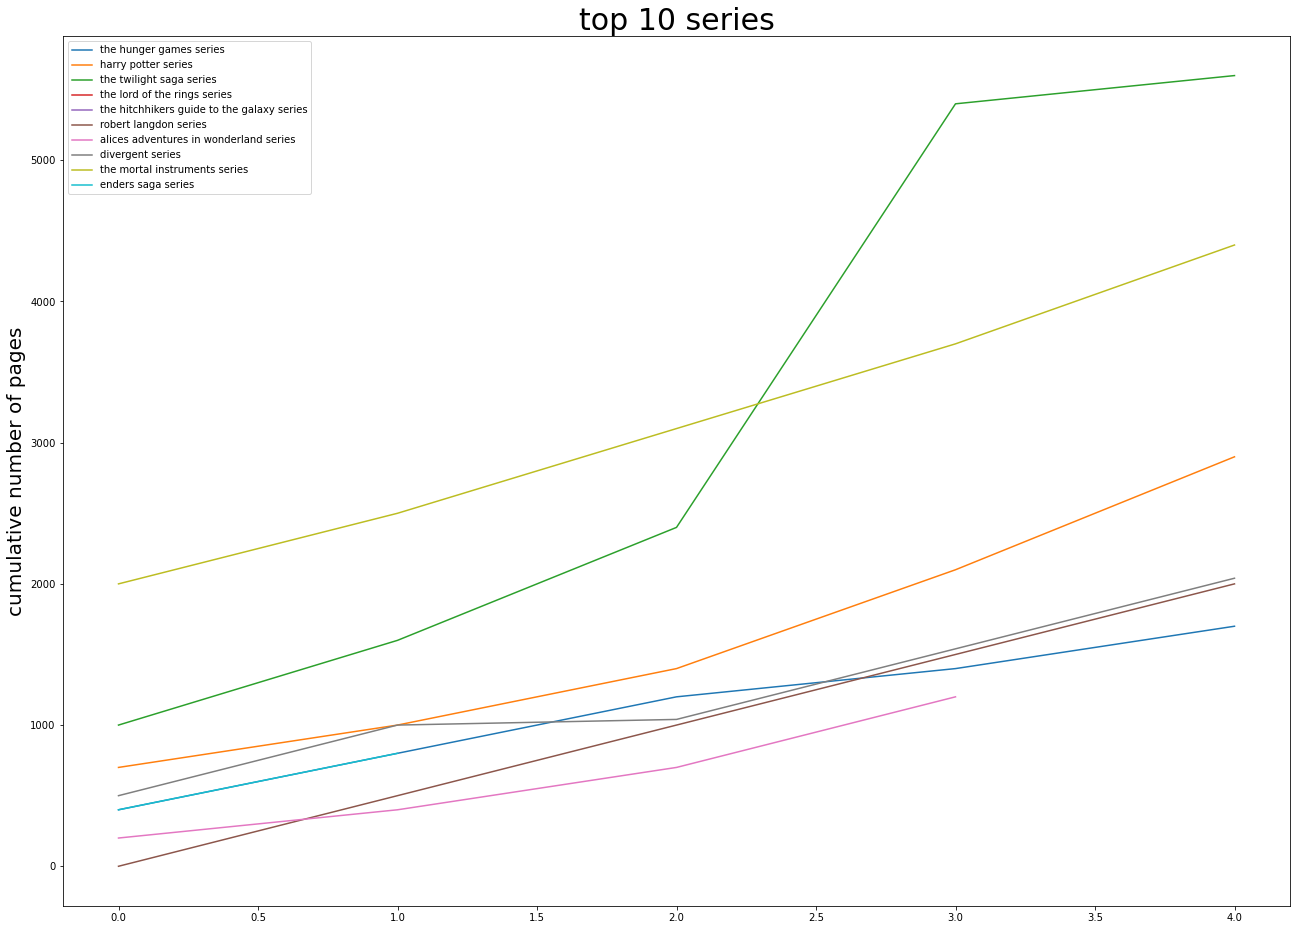

In [14]:
plt.figure(figsize=(22,16))
plt.ylabel('cumulative number of pages', fontsize=20)
plt.title('top 10 series', fontsize=30)
for series in top_series:
    s = search(' '.join(series))
    v = []
    for i in s['index']:
        r = n_ds[n_ds['index'] == i]
        v.append((int(r['publishingDate'].tolist()[-1][-1]), r['numberOfPages'].tolist()[-1]))
    v = sorted(v, key=lambda x: x[0])
    date = [t for t in range(len(v))]
    page = [t[1] for t in v]
    page = cumulativeCount(page)
    plt.plot(date, page, label = ' '.join(series) + ' series')
plt.legend()
plt.show()

# 5. Algorithmic Question

### Question ***1***

This is our recursive program: **subseq(**string**)** finds the maximum length of a subsequence of characters that is in alfabetical order

In [2]:
def inorder(s):
    t = True
    for i in range(1, len(s)):
        if ord(s[i-1]) >= ord(s[i]):
            t = False
    return t


def subseq_rec(string, s, i, l):
    if i == len(string):
        return l
    l.append(s+string[i])
    subseq_rec(string, s+string[i], i+1, l)
    subseq_rec(string, s, i+1, l)

def subseq(string):
    string = string.upper()
    l = []
    subseq_rec(string, '', 0, l)
    c = 0
    for p in l:
        if inorder(p):
            c = max(c, len(p))
    return c

To test our algorithm, let's try with the string "CADFECEILGJHABNOFPS"; we can observe that the longest subsequence of characters in alfabetical order is made of **9** characters (it could be 'ADEILNOPS' ("C***AD***F***E***CE***IL***GJHAB***NO***F***PS***"), or 'ACEILNOPS' ("C***A***DFE***CEIL***GJHAB***NO***F***PS***")......)

In [37]:
subseq("CADFECEILGJHABNOFPS")

9

### Question ***2***

Let's show that the running time of the algorithm is exponential.

We first try it with a short word:

In [3]:
%%time
subseq("DGGTTYHE")

Wall time: 0 ns


4

It just took ***998 µs*** to find to respond.

Now, let's try with a longer string:

In [57]:
%%time
subseq("DGGTTYGRFOEBOHE")

Wall time: 62 ms


4

.................and longer:

In [58]:
%%time
subseq("DGGTTIEOBVOEORUBOYHE")

Wall time: 2.17 s


7

..............................and longer:

In [59]:
%%time
subseq("DTVGTTIERBVOEOBWFIKRUBOYHE")

Wall time: 2min 51s


8

So, in our examples, as the word's length increases, even the running time increases as well:
 - if the word's lenght is 8, we obtain the output in ***998 µs***;
 - if the word's lenght is 15, we obtain the output in ***62 ms***;
 - if the word's lenght is 20, we obtain the output in ***2.17 s***;
 - if the word's lenght is 26, we obtain the output in ***2min 51s***;
 
So all results are obtained reasonable (still exponential) time.

But let's try to see if we can always obtain results in a reasonable time:

In [11]:
subseq("DTVGTTIERBVOOWEIFBWOWBFOWEFBWOSCBWONDPWEIKCCBOIEEOEOBWFIKRUBOYHE")

***Memory Error***!!! Our computer is not able to reach the solution.

It is probably a good idea to also visually compare the distribution of the runtime complexity of the algorithm when increasing the length of the string, one character at a time.

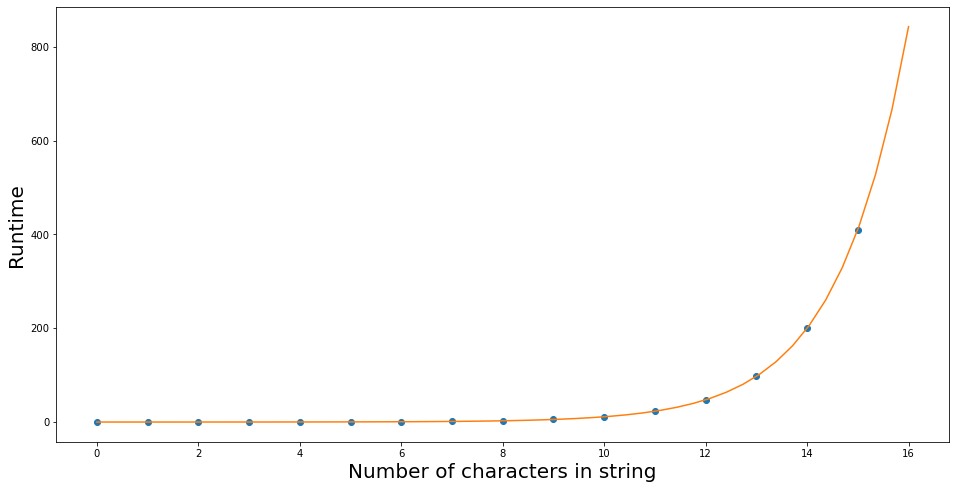

In [5]:
n = 16
x = [float(x) for x in range(n)]
y = []
s = 'DGGTTYHEOG'
a = time.time()

def exp_func(x, a, b, c):
    return a*np.exp(-b*x)+c

for k in range(n):
    s += random.choices(string.ascii_uppercase)[0]
    g = subseq(s)
    b = time.time()
    y.append(b-a)

popt, pcov = curve_fit(exp_func, x, y, p0=(1, 1e-6, 1))
xx = np.linspace(0,n)
yy = exp_func(xx, *popt)

plt.figure(figsize=(16,8))
plt.xlabel('Number of characters in string', fontsize=20)
plt.ylabel('Runtime', fontsize=20)
plt.plot(x,y,'o', xx, yy)
plt.show()

From the above plot it looks clear how such distribution is quite well approximated by an exponential

### Question ***3***

Now we still want to find the maximum length of a subsequence of characters in alphabetical order, but this time we want to reach the target using a dynamic program.

In [1]:
def dynamic_subq(s):
    a = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    s = s.upper()
    la = len(a)+1
    ls = len(s)+1
    # create matrix
    m = [list() for _ in range(la)]
    for i in range(la):
        m[i] = [0 for _ in range(ls)]
    # fill matrix
    for i in range(1, la):
        for j in range(1, ls):
            if a[i-1] == s[j-1]:
                m[i][j] = m[i-1][j-1]+1
            else:
                m[i][j] = max(m[i-1][j], m[i][j-1])
    # return value in cell n+1, m+1
    # where n is the number of char in alphabet
    # and m is the lenght of the input string
    return m[la-1][ls-1]

In [2]:
dynamic_subq('CIAO')

3

### Question 4

The running time of the dynamic algorithm is:
$O(2(nm)+c) = O(nm)$ 

where ***n*** is the lenght of the alphabet, and ***m*** is the length of the input word.

Because n=26 (so n is costant), the final running time depends only by m, that is:

$O(m)$

So if we try to test the dynamic program, we obtain:

In [14]:
%%time
dynamic_subq("DGGTTYHE")

Wall time: 0 ns


4

In [15]:
%%time
dynamic_subq("DGGTTYGRFOEBOHE")

Wall time: 0 ns


4

In [19]:
%%time
dynamic_subq("DGGTTIEOBVOEORUBOYHE")

Wall time: 0 ns


7

In [20]:
%%time
dynamic_subq("DTVGTTIERBVOEOBWFIKRUBOYHE")

Wall time: 0 ns


8

In [21]:
%%time
dynamic_subq("DTVGTTIERBVOOWEIFBWOWBFOWEFBWOSCBWONDPWEIKCCBOIEEOEOBWFIKRUBOYHE")


Wall time: 1 ms


10

 Word's lenght  | Recursive program | Dynamic Program | 
------------- |  ----------  | -----------| 
8| Time: ***998 µs*** | Time: ***0 ns*** | 
15| Time: ***86.3 ms*** | Time: ***0 ns***   |
20| Time: ***2.4 s***  | Time: ***0 ns*** | 
26| Time: ***3min 24s***  | Time: ***0 ns***   |
64| Time: Memory Error  | Time: ***1 ms*** | 

### BONUS:

$X[i]=\mathop{{max}\vphantom{\sim}}(1,\mathop{{max}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf j=0,...,i-1}}(1+X[j]))$

with 
 - $X[i] =$ length of the longest subsequence in alphabetic order that ends in the element at index $i$
 - $S[i]=$ element $i$ of the sequence of letters
 - $S[j]<S[i]$
 

### Proof:

We define an array $X[0,...,k]$, where $X[i]$ is the length of the longest subsequence in alphabetic order that ends in the element at index $i$.

We will compute this array gradually: first $X[0]$, then $X[1]$, $X[2]$, and so on. After this array is computed, the answer to the problem will be the maximum value in the array X.

So let the current index be $i$: we want to compute the value $X[i]$. All the previous values $X[0],…,X[i−1]$ are known.

It could happen that:


- $X[i]=1 \rightarrow $ subsequence consists of only the element $S[i]$
- $X[i]>1 \rightarrow $ There is another element $S[j]<S[i]$ (with $j=0,...,i-1$)  before the element $S[i]$; if we fix the index $j$, than the longest subsequence ending in the two elements $S[j]$ and $S[i]$ has the length $X[j]+1$.
 All of these values $X[j]$ are already known, so we can directly compute $X[i]$ with:
 
 $X[i]=\mathop{{max}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf j=0,...,i-1}}(1+X[j])$
 
 with $S[j]<S[i]$
 
 
Now, combininig these two cases, we get the final result for $X[i]$:

$X[i]=\mathop{{max}\vphantom{\sim}}(1,\mathop{{max}\vphantom{\sim}}\limits_{\displaystyle _{\mathbf j=0,...,i-1}}(1+X[j]))$

with $S[j]<S[i]$